In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import tensorflow as tf
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())



[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8910487547900631183
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4963368960
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4628414262737983517
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [4]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Filtro de Imagenes (Incluyendo unicamente primeras 3 clases)

In [5]:
filter_train_labels = train_labels < 3
filter_test_labels = test_labels < 3
train_images = train_images[filter_train_labels]
train_labels = train_labels[filter_train_labels]
test_images = test_images[filter_test_labels]
test_labels = test_labels[filter_test_labels]

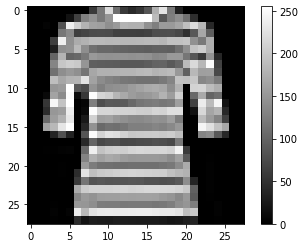

In [6]:
plt.imshow(train_images[9], cmap = 'gray')
plt.colorbar()

In [7]:
num_images, width, height = np.shape(train_images)
image_size = width * height
num_images, image_size
num_images_test = np.shape(test_images)[0]
num_images, num_images_test

(18000, 3000)

In [8]:
dict_labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}
num_labels = len(dict_labels)

### Datos sin Normalizacion

In [9]:
data_x = np.hstack((np.reshape(train_images,(num_images,-1)),np.ones((num_images,1))))  # incluyendo bias
data_x_test = np.hstack((np.reshape(test_images,(num_images_test,-1)),np.ones((num_images_test,1))))  # incluyendo bias
np.shape(data_x)
pd.DataFrame(data_x)

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,114.0,130.0,76.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,22.0,...,0.0,0.0,0.0,133.0,167.0,73.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,3.0,0.0,82.0,237.0,231.0,70.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,128.0,163.0,62.0,0.0,0.0,0.0,0.0,0.0,1.0
17998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Datos con Normalizacion usando media y desviacion estandar

In [10]:
data_x_norm = np.reshape(train_images,(num_images,-1))
x_mean = np.mean(data_x_norm, axis=0)
x_std = np.std(data_x_norm, axis=0)
data_x_norm = np.hstack(((data_x_norm-x_mean)/x_std,np.ones((num_images,1))))

# Transformacion data test con x media y x std de entrenamiento
data_x_norm_test = np.reshape(test_images,(num_images_test,-1))
data_x_norm_test = np.hstack((np.nan_to_num((data_x_norm_test-x_mean)/x_std),np.ones((num_images_test,1))))

print(np.shape(data_x_norm))
print(np.shape(data_x_norm_test))

(18000, 785)
(3000, 785)


## Definicion Softmax y Grafo

In [11]:
def softmax(tensor_logit):
    return tf.exp(tensor_logit)/tf.reduce_sum(tf.exp(tensor_logit),axis=1, keepdims=True)

In [12]:
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    weights = tf.Variable(tf.zeros((image_size+1,num_labels)), dtype=tf.float32, name = "weights")   #matriz de 785x10
    tensor_x = tf.placeholder(dtype=tf.float32,name="Images")
    tensor_test_x = tf.placeholder(dtype=tf.float32,name="Images_Test")
    tensor_y = tf.placeholder(dtype=tf.int32, name="Clases")
    tensor_test_y = tf.placeholder(dtype=tf.int32, name="Clases_Test")
    tensor_lr = tf.placeholder(dtype=tf.float32,name="LR")
    with tf.name_scope("OHE_Y"):
        ohe_y = tf.reshape(tf.one_hot(tensor_y, num_labels),(num_images,-1))
        ohe_y_test = tf.reshape(tf.one_hot(tensor_test_y, num_labels),(num_images,-1))
    with tf.name_scope("Logits"):
        logits_train = tf.linalg.matmul(tensor_x, weights, name="Logits")
        logits_test = tf.linalg.matmul(tensor_test_x, weights, name="Logits")
    with tf.name_scope("Softmax"):
        s_train = softmax(logits_train)
        s_test = softmax(logits_test)
    with tf.name_scope("Accuracy"):
        y_hat = tf.argmax(s_test, axis=1, output_type=tf.int32)
        accuracy = tf.reduce_sum(tf.cast(tf.equal(y_hat,tensor_test_y),tf.int32))/tf.shape(y_hat)[0]
        accuracy_summary = tf.summary.scalar("Accuracy",accuracy)
    with tf.name_scope("Loss"):
        loss = -1/num_images*tf.reduce_mean(ohe_y*tf.math.log(s_train) + (1-ohe_y)*tf.math.log(1-s_train))
        loss_summary = tf.summary.scalar("Loss",loss)
    with tf.name_scope("Gradient_Descent"):
        gradientes = tf.gradients(loss, weights)
        update_weights = tf.assign(weights,weights - tensor_lr*gradientes[0])        



## Funcion de Entrenamiento

In [34]:
def TrainingModel(dataX, dataY, dataX_test, dataY_test, epochs, batch_size, lr, normalization=False):
    total_iteraciones = int(np.shape(dataX)[0]/batch_size)

    tf.debugging.set_log_device_placement(True)
    tf.reset_default_graph()
    with tf.Session(graph=g) as session:
        writer = tf.summary.FileWriter('./graphs/Parte1/Tarea3.1-RegresionLogisticaMulticlase_normalization='+str(normalization)+'_epochs='+str(epochs)+'_batchsize='+str(batch_size)+'_lr='+str(lr), session.graph)
        init = tf.global_variables_initializer()
        session.run(init)
        j = 1
        for epoch in range(epochs):
            for i in range(total_iteraciones):
                muestra_inicio = i * batch_size
                muestra_fin = muestra_inicio + batch_size
                x = np.array(dataX[muestra_inicio:muestra_fin])
                y = np.array(dataY[muestra_inicio:muestra_fin])
                feed_dict = {tensor_x:dataX, tensor_y:dataY, tensor_lr: lr}
                parametros, loss_sum = session.run([update_weights, loss_summary],feed_dict=feed_dict)                
                writer.add_summary(loss_sum, j+1)
                j += 1
            feed_dict = {tensor_test_x: dataX_test, tensor_test_y: dataY_test}
            acc, accuracy_sum, best_params  = session.run([accuracy, accuracy_summary, weights],feed_dict=feed_dict)
            print("Epoch {} - Accuracy {}".format(epoch+1,acc))
            writer.add_summary(accuracy_sum, epoch+1)
        session.close()
        return(best_params)

## Entrenamiento Datos No Normalizados

In [48]:
params = TrainingModel(data_x, train_labels, data_x_test, test_labels, 5, 32, 0.15)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5

Epoch 1 - Accuracy 0.9586666666666667
Epoch 2 - Accuracy 0.9616666666666667
Epoch 3 - Accuracy 0.9626666666666667
Epoch 4 - Accuracy 0.964
Epoch 5 - Accuracy 0.964


## Mejor Modelo con datos NO normalizados
<img src="./images/best non normalize data.png">

## Entrenamiento Datos Normalizados

In [53]:
params_norm = TrainingModel(data_x_norm, train_labels, data_x_norm_test, test_labels, 15, 32, 0.000001, True)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5

Epoch 1 - Accuracy 0.882
Epoch 2 - Accuracy 0.8863333333333333
Epoch 3 - Accuracy 0.8893333333333333
Epoch 4 - Accuracy 0.8873333333333333
Epoch 5 - Accuracy 0.8926666666666667
Epoch 6 - Accuracy 0.889
Epoch 7 - Accuracy 0.8923333333333333
Epoch 8 - Accuracy 0.8916666666666667
Epoch 9 - Accuracy 0.8906666666666667
Epoch 10 - Accuracy 0.89
Epoch 11 - Accuracy 0.8886666666666667
Epoch 12 - Accuracy 0.8883333333333333
Epoch 13 - Accuracy 0.8896666666666667
Epoch 14 - Accuracy 0.8896666666666667
Epoch 15 - Accuracy 0.8883333333333333


## Mejor Modelo con datos normalizados
<img src="./images/best normalize data.png">

# Conclusion: Modelo con datos normalizados (epochs=5, batch_size=32, lr=0.15) es el que mejor accuracy proporciona
<img src="./images/best overall.png">

# Prediccion Datos Aleatorios

In [18]:
results = pd.DataFrame(np.stack((preds, train_labels), axis=1))
results.to_csv('results.csv')